# Creating GANs from Scractch

In [1]:
# formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % ( 60 * 60)) / 60)
    s = sec_elapsed % 60
    return f'{h}:{m:>02}:{s:>05.2f}'

## Implementing Deep Convolutional GANs in Keras

[Paper](https://arxiv.org/abs/1511.06434) that described the type of DCGAN that we will create in this module. This paper implements a DCGAN as follows:
- no pre-processing was applied to training images besides scaling to the range of the `tanh` activation function (i.e., -1 to 1)
- all models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128
- all weights were initialized from a zero-centered normal distribution with standard deviation 0.02
- in the `LeaklyReLU`, the slope of the leak was set to 0.2 in all models
- Adam optimizer with tuned hyperparameters (suggested learning rate of 0.001 is too high, using 0.0002 instead)
- additionally found that momentum term $\beta1$ at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training

The paper also provides the following architecture guidelines for stable DCGANs:
- replace any pooling layers with `strided convolutions` (discriminator) and `franctional-strided convolutions` (generator)
- use `batchnorm` in both the generator and the discriminator
- remove fully connected hidden layers for deeper architectures
- use `ReLU` activation in generator for all layers except for the output, which uses `Tanh`
- use `LeakyReLU` activation in the discriminator for all layers

While creating the material for this module, the following resources were used:
- [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan) (TensorFlow 2.0 example code)
- [Keep Calm and train a GAN. Pitfalls and Tips on training Generative Adversarial Networks](https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9)
- [Collection of Keras implementations of Generative Adversarial Networks GANs](https://github.com/eriklindernoren/Keras-GAN)
- [dcgan-facegenerator](https://github.com/platonovsimeon/dcgan-facegenerator) (semi-paywalled)

The program created next will generate faces similar to the images below. While these faces are not perfect, they demonstrate how we can construct and train a GAN on our own. Later, we will see how to import very advanced weights from nVidia to produce high resolution, realistic looking faces.

![gan-example](https://camo.githubusercontent.com/41a14c959276510a01dbc691e1cbea7dcbc14e593330b0157dd56ffe910e34fb/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6a656666686561746f6e2f7438315f3535385f646565705f6c6561726e696e672f6d61737465722f696d616765732f67616e2d332e706e67)

As discussed in the previous module, the GAN is made up of two different neural networks: the discriminator and the generator. The generator generates the images, while the discriminator detects if a face is real or was generated.

![discriminator-generator](https://camo.githubusercontent.com/b1e13e3090f27aa6a9451331de237b8f0ce38fa3d1ce53cfbb8e7514c9358f51/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6a656666686561746f6e2f7438315f3535385f646565705f6c6561726e696e672f6d61737465722f696d616765732f67616e5f6669675f312e706e67)

The discriminator accepts an image as its input and produces number that is the probability of the input image being real. The generator accepts a random seed vector and generates an image from that random vector seed. An unlimited number of new images can be created by providing additional seeds.

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [3]:
import tensorflow as tf

# keras modules
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

# data modules
import numpy as np
import pandas as pd

# notebook utilities
import os 
import time
from PIL import Image
from tqdm import tqdm

# graphing
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid', palette='viridis', context='talk')

There are the constants that define how the GANs will be created for this example. The higher the resolution, the more memory that will be needed. Higher resolution will also result in longer runtimes. For Google CoLab (GPU), 128x128 resolution is as high as can be used due to the available memory.

In [4]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note: GENERATE_RES 4 or higher will blow Google CoLab's memory and have not been tested extensively.

GENERATE_RES = 3 # Generation resolution factor (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = './res/data'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


Next, we will load and preprocess the images. Google CoLab will take an hour to process. But we can store the preprocessed file as a binary. This way, we can simply reload the processed training data and quickly use it. It is most efficient to only perform this operation once. The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change.

Image set has 7,000+ images so initial pre-processing can take over an hour. To save time, we can save to a Numpy file using Pickle.

> **_NOTE_**: File is large enough to cause problems for some versions of Pickle so numpy binary files are used.

In [5]:
training_binary_path = os.path.join(
    DATA_PATH,
    f'training data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f'Looking for file: {training_binary_path}.')

if not os.path.isfile(training_binary_path):
    
    start = time.time()
    print('Loading training images... ')
    
    training_data = []
    faces_path = os.path.join(DATA_PATH, 'gan-examples')
    
    for filename in tqdm(os.listdir(faces_path)):
        path = os.path.join(faces_path, filename)
        image = Image.open(path).resize(
            (GENERATE_SQUARE, GENERATE_SQUARE), Image.ANTIALIAS)
        training_data.append(np.asarray(image))
    
    training_data = np.reshape(
        training_data,
        (-1, GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS))
    training_data = training_data.astype(np.float32)
    training_data = training_data / 127.5 - 1
    
    print('Saving training image binary... ')
    
    np.save(training_binary_path, training_data)
    elapsed = time.time() - start
    
    print(f'Image pre-process time: {hms_string(elapsed)}')
    
else:
    print('Loading previous training Pickle... ')
    training_data = np.load(training_binary_path)
    

Looking for file: ./res/data/training data_96_96.npy.
Loading previous training Pickle... 


We will use a TensorFlow dataset object to actually hold the images. This allows the data to be quickly shuffled and divided into the appropriate batch sizes for training.

In [6]:
# batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-06-14 21:20:42.710490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-14 21:20:42.712550: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-14 21:20:42.713195: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (da65e3f7468d): /proc/driver/nvidia/version does not exist
2022-06-14 21:20:42.735949: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Next, we build the discriminator and the generator. Both will be trained with the Adam optimizer.

In [7]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

As we progress through training images will be produced to show the progress. These images will contain a number of rendered faces that show how good the generator has become.

In [8]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

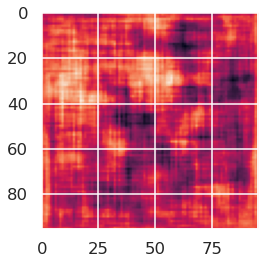

In [9]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])
plt.show()

In [10]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.500406]], shape=(1, 1), dtype=float32)


Loss functions must be developed that allow the generator and discriminator to be trained in an adversarial way. Because these two neural networks are being trained independently, they must be trained in two separate passes. This requires two separate loss functions and also two separate updates to the gradients.

When the discriminator's gradients are applied to decrease the discriminator's loss, it is important that only the discriminator's weights are updated. It is not fair (nor will it produce good results) to adversairially damage the weights of the generator to help the discriminator. A simple backpropagation would do this. It would simultaneously affect the weights of both generator and discriminator to lower whatever loss it was assigned to lower.

![disciminator network](https://camo.githubusercontent.com/1187aa69b00f2458175cedab0ad1940d6f17097afa57dd45e7ec4a821d3b2f9a/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6a656666686561746f6e2f7438315f3535385f646565705f6c6561726e696e672f6d61737465722f696d616765732f67616e5f6669675f322e706e67)

Here, a training set is generated with an equal number of real and fake images. The real images are randomly sampled (chosen) from the training data. An equal number of random images are generated from random seeds. For the discriminator training set, the `x` contains the input imaages and the `y` contains a value of 1 for real images and 0 for generated ones.

![generator-network](https://camo.githubusercontent.com/7558a94a81ec61f33b9853a2b7293700ab943ccfdaa464e9940f3339bd2f85cf/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6a656666686561746f6e2f7438315f3535385f646565705f6c6561726e696e672f6d61737465722f696d616765732f67616e5f6669675f332e706e67)

For the generator training set, the `x` contains the random seeds to generate images and the `y` contains the value of 1, because the optimal is for the generator to have genereated such good images the the discriminator was fooled into assigning them a probability near 1.

In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Both the generator and discriminator use Adam and the same learning rate and momentum. This does not need to be the case. If you use a `GENERATE_RES` greater than 3, you may need to tune these learning rates, as well as other training and hyperparameters.

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

The following function is where most of the training takes place for both the discriminator and the generator. This function was based on the GAN provided by the `keras` example documentation. The first thing to notice is that it is annotated with the `tf.function` annotation. This causes the function to be precompiled and improves performance.

This function trains differently than the code we previously saw for training. It uses `GradientTape` to allow the discriminator and generator to be trained together, yet separately.

In [13]:
# notice the use of `tf.function`
# this annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [14]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(
      0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))